# Pinecone 101 Webinar

The Pinecone Python client offers a user-friendly API that empowers developers to easily automate tasks and interact with the platform through the SDK. This makes it simple to create and manage vector indexes, perform efficient similarity searches, and handle large-scale machine learning and natural language processing workloads.

This notebook will guide you through the initial steps of using the Pinecone Serverless platform to perform the tasks shown in the diagram below:







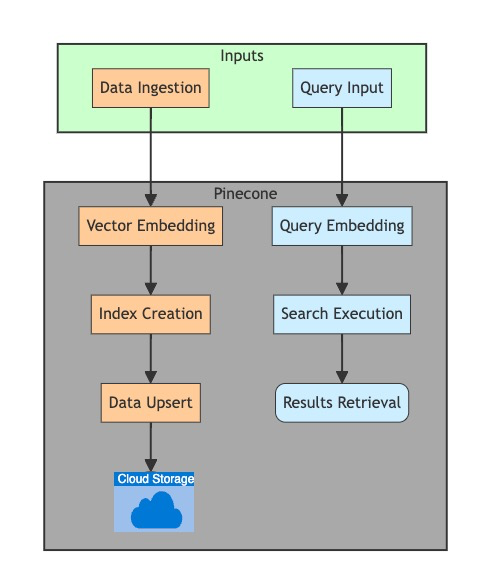

### Steps in This Notebook:

1. Load Libraries
2. Create Index
3. UPSERT Sample Data
4. Embed Query
5. Execute Search
6. View Results

The dataset we will be using consists of randomly generated doctor’s notes sample data. The original JSON data has been embedded into vectors, which we will load into Pinecone.

***Let’s go!***

## Install Libraries

In [ ]:
!pip install -qU pinecone-client==3.2.1 pinecone-notebooks tqdm



In [ ]:
from pinecone_notebooks.colab import Authenticate
Authenticate()

import os
import time
import pandas as pd
from google.colab import files
from pinecone import Pinecone, ServerlessSpec
from transformers import AutoTokenizer, AutoModel
import torch

## Initialize Pinecone Connection

In [ ]:
# Initialize connection to Pinecone (get API key at app.pinecone.io)
api_key = os.getenv('PINECONE_API_KEY')

# Configure Pinecone client
pc = Pinecone(api_key=api_key, source_tag='pinecone-notebooks:pinecone-101')

# Get cloud and region settings
cloud = os.getenv('PINECONE_CLOUD', 'aws')
region = os.getenv('PINECONE_REGION', 'us-east-1')

# Define serverless specifications
spec = ServerlessSpec(cloud=cloud, region=region)

# Define index name
index_name = 'pinecone101'

## Create Index

In [ ]:
# Check existing indexes
existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

if index_name not in existing_indexes:
    # Create index if it does not exist
    pc.create_index(index_name, dimension=384, metric='cosine', spec=spec)
    # Wait for index to be initialized
    while not pc.describe_index(index_name).status['ready']:
        time.sleep(1)
    print(f"Index {index_name} has been successfully created.")
else:
    print(f"Index {index_name} already exists.")

## Get Data
The data is based on simulated doctor's notes for numerous patients.

### Upload and Read Data

In [ ]:
# Step 1: Upload the file from your local machine to Google Colab
uploaded = files.upload()

# Step 2: Assuming the file is uploaded, read it into a DataFrame
file_name = next(iter(uploaded.keys()))
df = pd.read_json(file_name, orient='records', lines=True)

# Show head of the DataFrame
df.head()

### Connect to Index and Upload Data

In [ ]:
# Connect to index
index = pc.Index(index_name)
time.sleep(1)

# View index stats
index.describe_index_stats()

# Upsert data into index from DataFrame
index.upsert_from_dataframe(df)

## Embedding and Querying

### Define Embedding Function

In [ ]:
def get_embedding(input_question):
    model_name = 'sentence-transformers/all-MiniLM-L6-v2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    encoded_input = tokenizer(input_question, padding=True, truncation=True, return_tensors='pt')

    with torch.no_grad():
        model_output = model(**encoded_input)

    embedding = model_output.last_hidden_state[0].mean(dim=0)
    return embedding

### Build and Execute Query

In [ ]:
# Build a query to search
question = "what if my patient has knee pain"
query = get_embedding(question).tolist()

# Get results
results = index.query(vector=[query], top_k=3, include_metadata=True)

# Sort results by score in descending order
sorted_matches = sorted(results['matches'], key=lambda x: x['score'], reverse=True)

# Print results
print(f'Original question: {question}')
print('---\nResults:\n--------------')
for match in sorted_matches:
    print(f'ID: {match["id"]}')
    print(f'Score: {match["score"]}')
    print(f'Metadata: {match["metadata"]}')
    print('---')